<a href="https://colab.research.google.com/github/ReyhaneTaj/PINNs/blob/main/InversMode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q deepxde tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.7 MB/s eta 0:00:00


In [ ]:
!pip install -q --upgrade deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.8 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.091548 s

'compile' took 0.739580 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.22e-01, 2.79e-01]    [3.22e-01, 2.79e-01]    []  
1000      [3.10e-07, 1.06e-07]    [3.10e-07, 1.06e-07]    []  
2000      [2.66e-07, 9.49e-08]    [2.66e-07, 9.49e-08]    []  
3000      [2.11e-07, 8.40e-08]    [2.11e-07, 8.40e-08]    []  
4000      [1.23e-07, 5.58e-08]    [1.23e-07, 5.58e-08]    []  
5000      [1.49e-07, 5.83e-08]    [1.49e-07, 5.83e-08]    []  
6000      [1.11e-07, 4.42e-08]    [1.11e-07, 4.42e-08]    []  
7000      [8.66e-07, 8.47e-07]    [8.66e-07, 8.47e-07]    []  
8000      [3.72e-08, 1.87e-08]    [3.72e-08, 1.87e-08]    []  
9000      [3.16e-08, 1.35e-08]    [3.16e-08, 1.35e-08]    []  
10000     [2.11e-08, 2.97e-08]    [2.11e-08, 2.97e-08]    []  
11000     [1.31e-08, 4.90e-09]    [1.31e-08, 4.90e-09]    []  
12000     [1.12e-08, 3.33e-09]    [1.12e-08,

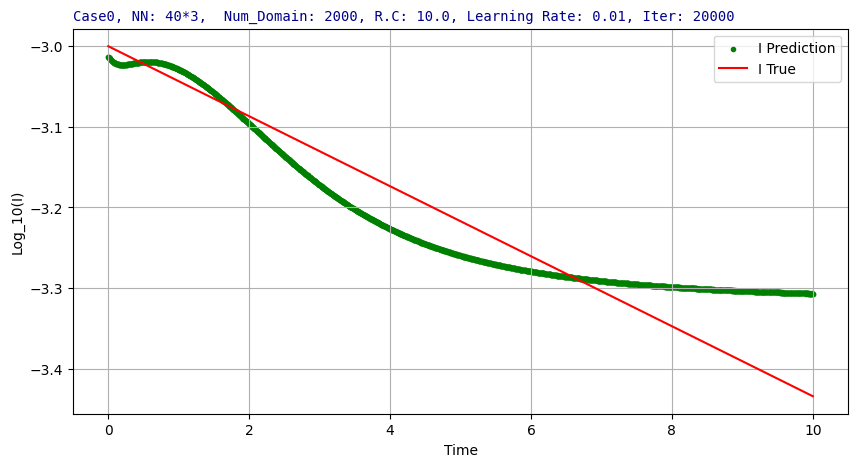

In [ ]:
#.....Case0_log10.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
#import random
import tensorflow as tf

#Set a seed for reproducibility
#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10.0
N_Domain = 2000
LR = 0.01
n = 40
l = 3
ITR = 20000
#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01
m = R_0*C_0
#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, R, C):
    return (U_dc / R) * np.exp(-t / (R * C))


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 100)  # Adjust the number of points as needed
    I_train = analytical_solution(t, R_0, C_0)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, I):
    dI_t = dde.grad.jacobian(I, t, i=0)
    return [dI_t + I / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X: U_dc / R , boundary, component=0)


# Get the train data
observe_t, ob_I = gen_traindata()
observe_I = dde.icbc.PointSetBC(observe_t, ob_I[:,0:1], component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [observe_I],
    num_domain= N_Domain,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [n] * l + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=0.01, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=ITR, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
I_pred = model.predict(t_test)
log_I_pred = np.log10(I_pred)

#Make true diagram
t_true = np.linspace(0, T, 20).reshape(-1, 1)
I_true = analytical_solution(t_true, R_0, C_0)
log_I_true = np.log10(I_true)

# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, log_I_pred, label='I Prediction', c='green' , marker='.')
# Plot log(I) True
plt.plot(t_true, log_I_true, label='I True', c='red')


plt.xlabel('Time')
plt.ylabel('Log_10(I)')
plt.legend()
plt.title(f'Case0, NN: {n}*{l},  Num_Domain: {N_Domain}, R.C: {m}, Learning Rate: {LR}, Iter: {ITR}', loc='left', fontdict={'family': 'monospace', 'color':  'darkblue', 'weight': 'normal', 'size': 10})
plt.grid(True)

plt.show()


In [ ]:
!cat variables.dat

cat: variables.dat: No such file or directory


Modified Activation Function!

Modify the Neural Network Output Activation:
Modify the neural network definition to use
tanh
⁡
tanh as the activation function for the layers, and then transform the output to the desired range (non-negative) using appropriate scaling and shifting:

In [ ]:
#.....Case0_log10.....#
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#Set a seed for reproducibility
#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Define constants for analytical part.
R_0 = 1000.0
C_0 = 0.01

#Time Limitation.
T = 100.0

#Define parameters as variables.
R = dde.Variable(1.0)
C = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, R, C):
    return (U_dc / R) * np.exp(-t / (R * C))


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 100)  # Adjust the number of points as needed
    I_train = analytical_solution(t, R_0, C_0)

    # Return the reshaped I_train, not a commented-out variable
    return np.reshape(t,(-1,1)), np.reshape(I_train,(-1,1))


# Define the Lorenz system
def Lorenz_system(t, I):
    dI_t = dde.grad.jacobian(I, t, i=0)
    return [dI_t + I / (R * C)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X: U_dc / R , boundary, component=0)


# Get the train data
observe_t, ob_I = gen_traindata()
observe_I = dde.icbc.PointSetBC(observe_t, ob_I[:,0:1], component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_I],
    num_domain=400,
    num_boundary=0,
    anchors=observe_t,
)

def tanh_transform(x):
    return (tf.tanh(x) + 1.0) / 2.0  # Transform tanh output to [0, 1] range

net = dde.nn.FNN([1] + [40] * 3 + [1], tanh_transform, "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=0.01, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])


# Make predictions
t_test = data.test_x
I_pred = model.predict(t_test)
log_I_pred = np.log10(I_pred)


# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, log_I_pred, label='log(I) Prediction', c='red' , marker='.')


plt.xlabel('Time')
plt.ylabel('log(I)')
plt.legend()
plt.title('Logarithm of I Prediction')
plt.grid(True)

plt.show()


ModuleNotFoundError: ignored

In [ ]:
!cat variables.dat

0 [1.00e+01, 5.00e+02, 2.00e-01]
600 [1.00e+01, 5.00e+02, 7.07e-02]
1200 [1.00e+01, 5.00e+02, 7.07e-02]
1800 [1.00e+01, 5.00e+02, 7.07e-02]
2400 [1.00e+01, 5.00e+02, 7.07e-02]
3000 [1.01e+01, 5.00e+02, 7.07e-02]
3600 [1.01e+01, 5.00e+02, 7.07e-02]
4200 [1.01e+01, 5.00e+02, 7.07e-02]
4800 [1.01e+01, 5.00e+02, 7.07e-02]
5400 [1.01e+01, 5.00e+02, 7.07e-02]
6000 [1.01e+01, 5.00e+02, 7.07e-02]
6600 [1.02e+01, 5.00e+02, 7.07e-02]
7200 [1.02e+01, 5.00e+02, 7.07e-02]
7800 [1.02e+01, 5.00e+02, 6.18e-02]
8400 [1.02e+01, 5.00e+02, 6.18e-02]
9000 [1.02e+01, 5.00e+02, 4.70e-02]
9600 [1.02e+01, 5.00e+02, 4.69e-02]
10200 [1.02e+01, 5.00e+02, 4.69e-02]
10800 [1.01e+01, 5.00e+02, 3.39e-02]
11400 [1.01e+01, 5.00e+02, 2.54e-02]
12000 [1.01e+01, 5.00e+02, 2.20e-02]
12600 [1.01e+01, 5.00e+02, 1.29e-02]
13200 [1.00e+01, 5.00e+02, 3.17e-03]
13800 [1.00e+01, 5.00e+02, -1.82e-03]
14400 [1.01e+01, 5.00e+02, -8.82e-03]
15000 [1.02e+01, 5.00e+02, -1.64e-02]
15600 [1.02e+01, 5.00e+02, -1.82e-02]
16200 [1.02e+01, 5

Compiling model...
Building feed-forward neural network...
'build' took 0.147299 s

'compile' took 0.903408 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.15e+00, 1.21e+00, 1.11e-01]    [1.15e+00, 1.21e+00, 1.11e-01]    []  
1000      [1.41e-02, 9.33e-04, 2.65e-02]    [1.41e-02, 9.33e-04, 2.65e-02]    []  
2000      [7.96e-03, 4.40e-04, 1.47e-02]    [7.96e-03, 4.40e-04, 1.47e-02]    []  
3000      [5.22e-03, 2.05e-04, 9.59e-03]    [5.22e-03, 2.05e-04, 9.59e-03]    []  
4000      [3.66e-03, 4.84e-05, 6.01e-03]    [3.66e-03, 4.84e-05, 6.01e-03]    []  
5000      [2.80e-03, 1.31e-05, 3.79e-03]    [2.80e-03, 1.31e-05, 3.79e-03]    []  
6000      [1.96e-03, 4.03e-05, 3.25e-03]    [1.96e-03, 4.03e-05, 3.25e-03]    []  
7000      [1.63e-03, 6.27e-06, 2.34e-03]    [1.63e-03, 6.27e-06, 2.34e-03]    []  
8000      [2.32e-03, 3.43e-04, 1.29e-03]    [2.32e-03, 3.43e-04, 1.29e-03]    []  
9000      [9.47e-04, 3.96e-06, 1.

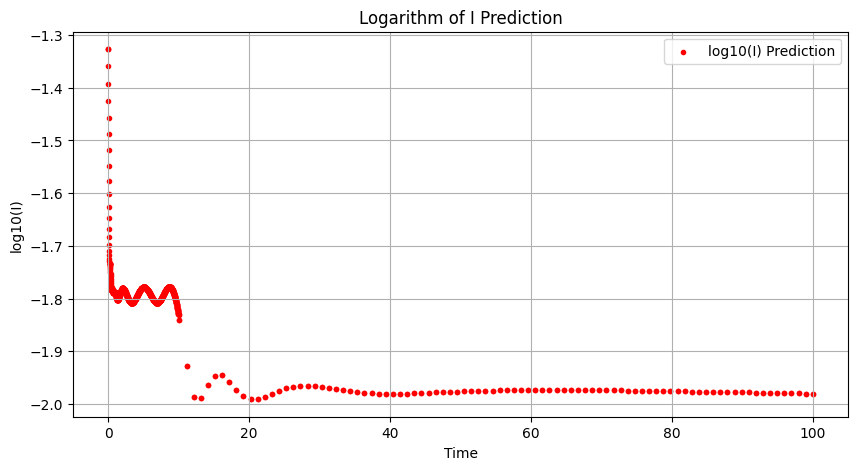

In [ ]:
####...Case1_log10...####
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#Set a seed for reproducibility
#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 100.0

#Define constants for analytical part.
R_0 = 500.0
R_1 = 1000.0
C_1 = 0.01
m = R_1*C_1
#Time Limitation.
T = 10.0
N_Domain = 2000
LR = 0.01
n = 40
l = 3
ITR = 20000
#Define constants for analytical part.

#Define parameters as variables.
Rr = dde.Variable(1.0)
R = dde.Variable(10.0)
C = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, Rr, R, C):
    return [((U_dc/R) * ((np.exp(-t/(R * C)))) + (U_dc/Rr))]


def gen_traindata():
    # Generate training data using the analytical solution
    t = np.linspace(0.0, T, 100)  # Adjust the number of points as needed
    I_train = analytical_solution(t, R_0, R_1, C_1)

    return np.reshape(t,(-1,1)), np.reshape(I_train,(-1,1))# I_train #


# Define the Lorenz system
def Lorenz_system(t, I):
    """Lorenz for I = (U_dc / R_0) - R_1 * C_1 * (dI/dt)"""
    I = I[:, 0:1]
    dI_dt = dde.grad.jacobian(I, t)
    return [(R * C*dI_dt) + I - (U_dc / Rr)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, 10)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X: U_dc * (1/Rr + 1/R), boundary, component=0)


# Get the train data
observe_t, ob_I = gen_traindata()
observe_I = dde.icbc.PointSetBC(observe_t, ob_I[:,0:1], component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_I],
    num_domain=1000,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [Rr, R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=0.01, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])

# Make predictions
t_test = data.test_x
I_pred = model.predict(t_test)
log_I_pred = np.log10(I_pred)


# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, log_I_pred, label='log10(I) Prediction', c='red' , marker='.')


plt.xlabel('Time')
plt.ylabel('log10(I)')
plt.legend()
plt.title('Logarithm of I Prediction')
plt.grid(True)

plt.show()


In [ ]:
!cat variables.dat

0 [1.00e+00, 1.00e+00, 1.00e+00]
600 [2.02e+00, 1.39e+00, 1.80e-01]
1200 [2.62e+00, 1.65e+00, 1.01e-01]
1800 [3.10e+00, 1.89e+00, 7.70e-02]
2400 [3.53e+00, 2.13e+00, 6.54e-02]
3000 [3.95e+00, 2.36e+00, 5.51e-02]
3600 [4.36e+00, 2.60e+00, 4.53e-02]
4200 [4.77e+00, 2.84e+00, 3.81e-02]
4800 [5.20e+00, 3.09e+00, 3.22e-02]
5400 [5.64e+00, 3.36e+00, 2.72e-02]
6000 [6.11e+00, 3.64e+00, 2.22e-02]
6600 [6.61e+00, 3.94e+00, 1.91e-02]
7200 [7.15e+00, 4.25e+00, 1.66e-02]
7800 [7.71e+00, 4.59e+00, 1.45e-02]
8400 [8.31e+00, 4.95e+00, 1.28e-02]
9000 [8.95e+00, 5.33e+00, 1.07e-02]
9600 [9.63e+00, 5.74e+00, 9.33e-03]
10200 [1.04e+01, 6.19e+00, 8.81e-03]
10800 [1.12e+01, 6.53e+00, 8.89e-03]
11400 [1.20e+01, 6.93e+00, 8.05e-03]
12000 [1.29e+01, 7.38e+00, 6.73e-03]
12600 [1.38e+01, 7.87e+00, 1.26e-02]
13200 [1.48e+01, 8.38e+00, 1.24e-02]
13800 [1.59e+01, 8.89e+00, 1.23e-02]
14400 [1.70e+01, 9.43e+00, 1.00e-02]
15000 [1.82e+01, 9.97e+00, 9.01e-03]
15600 [1.95e+01, 1.05e+01, 8.64e-03]
16200 [2.09e+01, 1.11e

In [ ]:
!pip install -q deepxde tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.6 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.085722 s

'compile' took 2.483899 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.74e+00, 4.00e+00, 1.21e+00]    [4.74e+00, 4.00e+00, 1.21e+00]    []  
1000      [2.69e-02, 1.02e-04, 3.58e-02]    [2.69e-02, 1.02e-04, 3.58e-02]    []  
2000      [1.45e-02, 5.64e-05, 2.00e-02]    [1.45e-02, 5.64e-05, 2.00e-02]    []  
3000      [9.55e-03, 3.80e-05, 1.33e-02]    [9.55e-03, 3.80e-05, 1.33e-02]    []  
4000      [6.76e-03, 2.80e-05, 9.53e-03]    [6.76e-03, 2.80e-05, 9.53e-03]    []  
5000      [4.95e-03, 2.04e-05, 7.06e-03]    [4.95e-03, 2.04e-05, 7.06e-03]    []  
6000      [3.69e-03, 1.55e-05, 5.32e-03]    [3.69e-03, 1.55e-05, 5.32e-03]    []  
7000      [2.74e-03, 9.29e-06, 4.09e-03]    [2.74e-03, 9.29e-06, 4.09e-03]    []  
8000      [1.37e-03, 1.90e-05, 3.98e-03]    [1.37e-03, 1.90e-05, 3.98e-03]    []  
9000      [1.64e-03, 6.66e-06, 2.

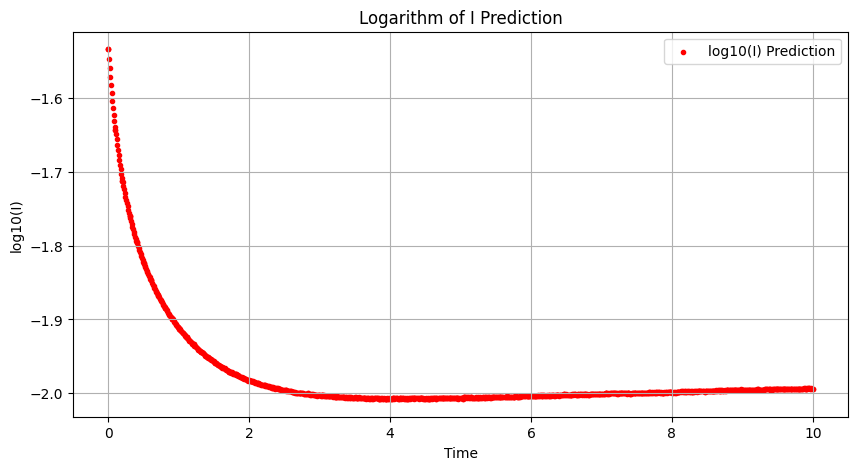

In [ ]:
####...Case1_log10_Noise...####
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#Set a seed for reproducibility
#seed = 0
#random.seed(seed)
#np.random.seed(seed)
#tf.random.set_seed(seed)

#Define constants.
U_dc = 1.0

#Time Limitation.
T = 10.0

#Define constants for analytical part.
R_0 = 100.0
R_1 = 1000.0
C_1 = 0.01

#Define parameters as variables.
Rr = dde.Variable(1.0)
R = dde.Variable(1.0)
C = dde.Variable(1.0)

# Define the analytical solution for dI/dt + I/(RC) = 0
def analytical_solution(t, Rr, R, C):
    return [((U_dc/R) * ((np.exp(-t/(R * C)))) + (U_dc/Rr))]


def gen_traindata(noise_stddev=0.01):
    # Generate training data using the analytical solution with noise
    t = np.linspace(0.0, T, 100)  # Adjust the number of points as needed
    I_clean = analytical_solution(t, R_0, R_1, C_1)

    # Add random noise to the clean data
    noise = np.random.normal(0, noise_stddev, len(t))
    I_train = I_clean + noise

    return np.reshape(t, (-1, 1)), np.reshape(I_train, (-1, 1))


# Define the Lorenz system
def Lorenz_system(t, I):
    """Lorenz for I = (U_dc / R_0) - R_1 * C_1 * (dI/dt)"""
    I = I[:, 0:1]
    dI_dt = dde.grad.jacobian(I, t)
    return [(R * C*dI_dt) + I - (U_dc / Rr)]

def boundary(_, on_initial):
    return on_initial

geom = dde.geometry.TimeDomain(0, T)

# Initial conditions
ic0 = dde.icbc.IC(geom, lambda X: U_dc * (1/Rr + 1/R), boundary, component=0)


# Get the train data
observe_t, ob_I = gen_traindata()
observe_I = dde.icbc.PointSetBC(observe_t, ob_I[:,0:1], component=0)


data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic0, observe_I],
    num_domain=1000,
    num_boundary=0,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

external_trainable_variables = [Rr, R, C]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

# Train using adam
model.compile(
    "adam", lr=0.01, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=20000, callbacks=[variable])

# Train using L-BFGS
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])

# Make predictions
t_test = data.test_x
I_pred = model.predict(t_test)
log_I_pred = np.log10(I_pred)


# Create a single figure for all plots
plt.figure(figsize=(10, 5))

# Plot log(I) Prediction
plt.scatter(t_test, log_I_pred, label='log10(I) Prediction', c='red' , marker='.')


plt.xlabel('Time')
plt.ylabel('log10(I)')
plt.legend()
plt.title('Logarithm of I Prediction')
plt.grid(True)

plt.show()


In [ ]:
!cat variables.dat

0 [1.00e+00, 1.00e+00, 1.00e+00]
600 [2.42e+00, 1.48e+00, 2.87e-02]
1200 [3.16e+00, 1.73e+00, 1.87e-02]
1800 [3.76e+00, 1.96e+00, 1.47e-02]
2400 [4.29e+00, 2.19e+00, 1.25e-02]
3000 [4.81e+00, 2.42e+00, 1.19e-02]
3600 [5.32e+00, 2.65e+00, 9.57e-03]
4200 [5.83e+00, 2.89e+00, 8.89e-03]
4800 [6.36e+00, 3.14e+00, 7.74e-03]
5400 [6.91e+00, 3.40e+00, 7.21e-03]
6000 [7.48e+00, 3.68e+00, 6.69e-03]
6600 [8.09e+00, 3.98e+00, 5.80e-03]
7200 [8.74e+00, 4.29e+00, 5.22e-03]
7800 [9.42e+00, 4.63e+00, 5.09e-03]
8400 [1.01e+01, 4.98e+00, 4.31e-03]
9000 [1.09e+01, 5.36e+00, 3.71e-03]
9600 [1.18e+01, 5.77e+00, 3.49e-03]
10200 [1.26e+01, 6.21e+00, 3.64e-03]
10800 [1.36e+01, 6.65e+00, 3.95e-03]
11400 [1.46e+01, 7.13e+00, 3.74e-03]
12000 [1.56e+01, 7.62e+00, 3.00e-03]
12600 [1.68e+01, 8.15e+00, 2.78e-03]
13200 [1.80e+01, 8.73e+00, 2.16e-03]
13800 [1.93e+01, 9.35e+00, 1.38e-03]
14400 [2.06e+01, 1.00e+01, 1.65e-03]
15000 [2.19e+01, 1.06e+01, 3.41e-03]
15600 [2.33e+01, 1.09e+01, 2.80e-03]
16200 [2.47e+01, 1.13e